In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=cpu"
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.recurrent import LSTM
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras

In [186]:
# Load the dataset ...
# You will need to separately download or generate this file from
# https://www.deepsig.io/datasets
# The file to get is RML2016.10a.tar.bz2
 
# you need an absolute path the file decompressed file so change the path.
# It is a pickle file for Python2 so a little extra code is needed to open it.
with open("/content/drive/MyDrive/Data/RML2016.10a_dict.dat", 'rb') as f:
    Xd = cPickle.load(f, encoding="latin1") 
 
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
snrs_chosen = [2, 4, 6, 8, 10, 12,14,16,18]
mods_chosen = ['WBFM', 'AM-SSB', 'GFSK']
#mods_chosen = ['BPSK', 'QAM16', 'QPSK', 'WBFM','AM-DSB', 'AM-SSB']

X = []
lbl = []
for mod in mods_chosen:
    # mod is the label. mod = modulation scheme
    for snr in snrs_chosen :
        X.append(Xd[(mod,snr)])
        #snr = signal to noise ratio
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
print(mods)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [179]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2015)
n_examples = X.shape[0]
# looks like taking half the samples for training
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
 
    data = list(yy)
 
    yy1 = np.zeros([len(data), max(data)+1])
    yy1[np.arange(len(data)),data] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods_chosen.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods_chosen.index(lbl[x][0]), test_idx))

In [188]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods_chosen

(18900, 2, 128) [2, 128]


In [180]:
# Build VT-CNN2 Neural Net model using Keras primitives --
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 1 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization
 
dr = 0.5 # dropout rate (%)
 
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0, 1)))
model.add(Conv2D(3, (1, 2), activation='relu', padding='valid', input_shape=(1, 2, 128), kernel_initializer='glorot_uniform'))
model.add(Flatten())
#model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense( len(classes),activation='relu', kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.build()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 2, 130, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 129, 3)         9         
_________________________________________________________________
flatten_8 (Flatten)          (None, 774)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 2325      
_________________________________________________________________
activation_8 (Activation)    (None, 3)                 0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 3)                

In [187]:
# Set up some params
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size

In [189]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
#weight written to jupyter directory (where notebook is). saved in hdf5 format.
 
#netron can open the h5 and show architecture of the neural network
filepath = '/content/drive/MyDrive/Data/3convmodrecnets_CNN2_0.5.wts.h5'
# history = model.fit(X_train,
#     Y_train,
#     batch_size=batch_size,
#     epochs=nb_epoch,
#     verbose=2,
#     validation_data=(X_test, Y_test),
#     callbacks = [
#         #params determine when to save weights to file. Happens periodically during fit.
#         keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
#         keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
#     ])
# we re-load the best weights once training is finished. best means lowest loss values for test/validation
model.load_weights(filepath)

In [190]:
from tensorflow.keras.models import Model
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

0.5455338358879089


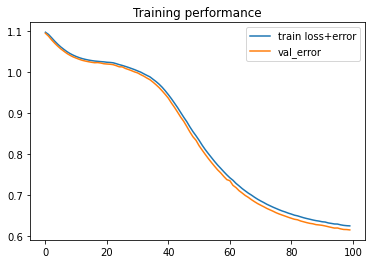

In [70]:
# Show loss curves
# this is both on training and validation data, hence two curves. They track well.
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [118]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[0.81219603 0.08342686 0.1043771 ]
 [0.         1.         0.        ]
 [0.03672107 0.02967359 0.93360534]]
['WBFM', 'AM-SSB', 'GFSK']


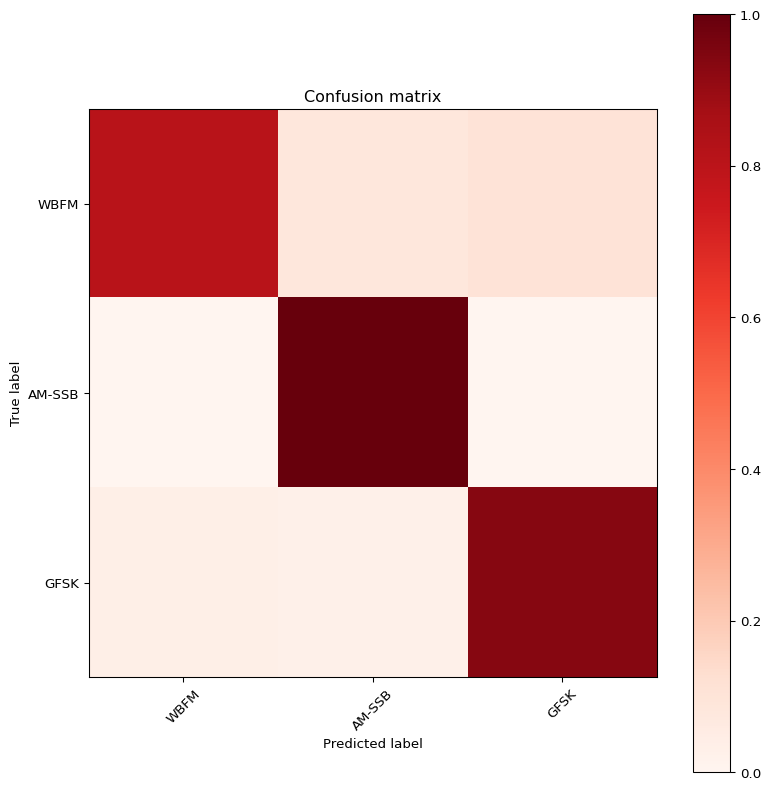

In [191]:
# Plot confusion matrix
 
#pass in X_test value and it predicts test_Y_hat
test_Y_hat = model.predict(X_test, batch_size=batch_size)
#fill matrices with zeros
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(Y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

# Testing Code

In [ ]:
print(X_test[2])

[[-4.32846718e-04  1.58037117e-03  1.32900022e-03  4.63560736e-03
  -4.60126670e-03  3.15797632e-03  2.78394693e-03  1.45412807e-03
  -5.46427967e-04 -5.65723058e-05  4.16845409e-03  3.19706160e-03
   3.50089953e-03  3.50062805e-03  1.88844104e-03  5.47146983e-03
   3.73216975e-03  4.84909443e-03  3.31629184e-03  2.50354013e-03
   4.29720664e-03  5.27014444e-03 -4.81206022e-04  1.34370732e-03
   2.30135513e-03  3.73544800e-03  9.13045253e-04  1.21917261e-03
   1.69913855e-03 -4.91880113e-04  1.19599316e-03  2.85250181e-03
   4.02119709e-03 -7.73538020e-04  1.65568304e-03  3.48196365e-03
   3.86397936e-03  3.65238055e-03  5.20670973e-03 -2.87439412e-04
   8.80537205e-04  4.63250047e-03 -8.53190373e-04  4.48308513e-03
   3.34260549e-04 -2.02292739e-03 -1.24000770e-03  1.65653974e-03
   1.72670625e-04 -4.22846293e-04  1.78678404e-03  2.87570315e-03
  -1.66628219e-03  9.42106300e-04  2.35861121e-03  1.81115756e-03
   3.05265142e-03 -9.07402020e-04  3.09089245e-03  2.99899816e-03
   2.99848

In [87]:
# Printing out the different layers
print(model.layers[0]) # Reshape
print(model.layers[1]) # Zero Padding
print(model.layers[2]) # Convolution + ReLU
print(model.layers[3]) # Flatten
print(model.layers[4]) # Dense + ReLU
print(model.layers[5]) # Softmax

In [ ]:
# First Image = X_test[0]
# I Values (128) = X_test[0][0]
# Q Values (128) = X_test[0][1]
print("I Data (128)")
print(X_test[3][0])
print("Q Data (128)")
print(X_test[3][1])


I Data (128)
[ 1.3831852e-03 -1.0368110e-03  9.7204174e-04  1.9952364e-03
  1.6522730e-03  1.7897430e-04  5.7696821e-03  3.5470414e-03
 -1.3577498e-03  3.0985675e-03  1.9041166e-03  5.3709344e-04
  1.5630516e-03  3.3981989e-03  2.1848348e-03  4.7774590e-03
  3.6289154e-03  4.0770886e-03  4.0836954e-03  1.4314982e-03
  1.5584420e-03 -1.2319535e-03  1.3344147e-03  5.3532827e-03
  3.7752237e-04  2.8742400e-03  4.4670710e-03 -7.1708177e-04
 -2.9502732e-03  4.1555008e-03  1.0936555e-03  1.3361470e-03
  1.6965572e-04  2.9613241e-03  1.5053847e-03  3.1870550e-03
  8.9460511e-05  2.6477233e-03  1.4188950e-03  4.6743280e-03
  4.5386180e-03  1.5972131e-03  3.9350362e-03  2.7357772e-04
  4.5220419e-03 -1.5149020e-03 -4.6250253e-04  1.5855765e-03
 -1.2071087e-03  1.4855304e-03  3.3384276e-04  7.5379517e-03
 -2.0245902e-04  1.0013165e-03  1.4362212e-03  7.4928255e-05
 -1.2314479e-03  4.7300654e-03  2.8924891e-03  1.4707427e-03
  1.3786864e-03  2.4635280e-03  2.0309491e-03  4.7702328e-03
  1.6276231

In [193]:
model2 = Model(inputs = model.inputs, outputs = model.layers[4].output) # output is dense and no softmax
model2.compile(loss='categorical_crossentropy', optimizer='adam')

model3 = Model(inputs = model.inputs, outputs = model.layers[3].output) # out is flatten array before dense
model3.compile(loss='categorical_crossentropy', optimizer='adam')

model4 = Model(inputs = model.inputs, outputs = model.layers[2].output) # out is conv out + relu
model4.compile(loss='categorical_crossentropy', optimizer='adam')

model5 = Model(inputs = model.inputs, outputs = model.layers[5].output) # out is conv out + relu
model5.compile(loss='categorical_crossentropy', optimizer='adam')



# #output_conv_relu = model3.predict(np.array([X_test[2],]))
# for i in range (2000, 3000):
#   print(i)
#   output_dense = model2.predict(np.array([X_test[i],]))
#   print(output_dense[0])

#output_dense = model2.predict(np.array([X_test[2053],]))
#output_non_flatten = model4.predict(np.array([X_test[2],]))
#print(output_dense[0])

In [196]:
# for i in range (7000, 8000):
#   print(i)
newTest1 = np.array([X_test[2000],])
newTest1[0][0][64:128] = np.zeros(64)
newTest1[0][1][64:128] = np.zeros(64)
print(newTest1)
output_dense = model2.predict(newTest1)
print(output_dense[0])




# newTest2 = np.array([X_test[3000],])
# #print(newTest)
# output_dense = model2.predict(newTest2)
# print(output_dense[0])

# newTest3 = np.array([X_test[7000],])
# #print(newTest)
# output_dense = model2.predict(newTest3)
# print(output_dense[0])


[[[ 0.00340702  0.00315039  0.00333857  0.00340607  0.00333929
    0.00340801  0.0033016   0.00329735  0.00327843  0.00335863
    0.003359    0.00317477  0.00317438  0.00327924  0.00346475
    0.00308912  0.00334424  0.00323422  0.00321405  0.00329245
    0.00323758  0.00323887  0.00324554  0.00317086  0.00345105
    0.00335841  0.00332846  0.00310473  0.00319262  0.0032274
    0.00322704  0.00337034  0.00339246  0.00337021  0.00339225
    0.00338993  0.00339248  0.00339003  0.00313194  0.00329693
    0.00323842  0.0033924   0.00330006  0.00331627  0.00325071
    0.0033381   0.00333713  0.00325184  0.00342337  0.00307509
    0.00339626  0.00355629  0.00355634  0.00323541  0.0032936
    0.00310939  0.00339621  0.00352378  0.00339385  0.00340698
    0.00317945  0.0031552   0.00317917  0.00315471  0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.
    0.          0.        

In [ ]:
import collections

print(output_conv_relu[0])
print("First 10 Values")
print((output_conv_relu[0][0]))
print((output_conv_relu[0][1]))
print((output_conv_relu[0][2]))
print((output_conv_relu[0][3]))
print((output_conv_relu[0][4]))
print((output_conv_relu[0][5]))
print((output_conv_relu[0][6]))
print((output_conv_relu[0][7]))
print((output_conv_relu[0][8]))
print((output_conv_relu[0][9]))
print("next 10")
print((output_conv_relu[0][10]))
print((output_conv_relu[0][11]))
print((output_conv_relu[0][12]))
print((output_conv_relu[0][13]))
print((output_conv_relu[0][14]))
print((output_conv_relu[0][15]))
print((output_conv_relu[0][16]))
print((output_conv_relu[0][17]))



#print(float2fix(output_conv_relu[0][0], 18, 12))
print('Last Value')
print((output_conv_relu[0][2579]))
#print(float2fix(output_conv_relu[0][2579], 18, 12))


# num_zeros = (output_conv_relu[0] == 0).sum()
# print(num_zeros)

# print((output_non_flatten))
# print(len(output_non_flatten[0][0]))
# print(len(output_non_flatten[0][1]))

[0.00037736 0.02185566 0.03013811 ... 0.01662675 0.00698425 0.        ]
First 10 Values
0.00037735794
0.021855664
0.030138113
0.020153409
0.013227453
0.027147299
0.012587775
0.026782807
0.015692664
0.0011494819
next 10
0.0
0.023901317
0.03223463
0.0178456
0.015020326
0.025378946
0.010808566
0.02912351
Last Value
0.0


In [ ]:
print(output_non_flatten.shape)
print("I Value, 1st Sample")
print((output_non_flatten[0][0][0]))
print("Q value, 1st Sample")
print((output_non_flatten[0][1][0]))
print("I value, 2nd Sample")
print((output_non_flatten[0][0][1]))
print("Q value, 2nd Sample")
print((output_non_flatten[0][1][1]))
print((output_non_flatten[0][1][128]))

(1, 2, 129, 10)
I Value, 1st Sample
[2.1733684e-03 1.8774929e-02 1.5647661e-02 0.0000000e+00 7.0459908e-05
 0.0000000e+00 1.9922696e-02 1.9272076e-02 5.8931507e-02 5.9914581e-02]
Q value, 1st Sample
[0.         0.02460763 0.02233089 0.01295923 0.         0.00714993
 0.03051572 0.02702559 0.05312144 0.04946252]
I value, 2nd Sample
[0.         0.0187649  0.0162795  0.00357886 0.         0.
 0.02147183 0.01989906 0.05885772 0.05816655]
Q value, 2nd Sample
[0.00359977 0.03322165 0.02805731 0.00186769 0.         0.01807124
 0.03606475 0.03435209 0.04508046 0.04540119]
[0.00727758 0.02403    0.01958683 0.         0.00439868 0.00205367
 0.02439381 0.0241853  0.05396799 0.05621343]


In [ ]:
print(output_dense[0])

[3.510959  3.1282985 4.310499 ]


# Translating Test Example to Binary

In [26]:
#val is the float
#width is final length of binary
#precision is how many points to be used for the fractional
def float2fix(val, width, precision):
    integer = abs(int(val * 2 ** precision))
    if val < 0:
        integer = 2 ** (width-1) - integer
    if val >= 0:
        fix_str = bin(integer).replace('0b', '').rjust(width, '0')
    else:
        fix_str = '1'+bin(integer).replace('0b', '').rjust(width-1, '0')
    return fix_str

In [197]:
combined_list = []

for x in newTest1[0][0]:
    #I Values
    combined_list.append(float2fix(x, 18, 12))
for x in newTest1[0][1]:
    #Q Values
    combined_list.append(float2fix(x, 18, 12))
 
for x in range(len(combined_list)):
    if (x < 10):
        print("18'd" + "0" +"0" + str(x) + ": data = 18'b" + str(combined_list[x]) + ";")
    elif (x < 100):
        print("18'd" + "0" + str(x) + ": data = 18'b" + str(combined_list[x]) + ";")
    else:
        print("18'd" + str(x) + ": data = 18'b" + str(combined_list[x]) + ";")
  

18'd000: data = 18'b000000000000001101;
18'd001: data = 18'b000000000000001100;
18'd002: data = 18'b000000000000001101;
18'd003: data = 18'b000000000000001101;
18'd004: data = 18'b000000000000001101;
18'd005: data = 18'b000000000000001101;
18'd006: data = 18'b000000000000001101;
18'd007: data = 18'b000000000000001101;
18'd008: data = 18'b000000000000001101;
18'd009: data = 18'b000000000000001101;
18'd010: data = 18'b000000000000001101;
18'd011: data = 18'b000000000000001101;
18'd012: data = 18'b000000000000001101;
18'd013: data = 18'b000000000000001101;
18'd014: data = 18'b000000000000001110;
18'd015: data = 18'b000000000000001100;
18'd016: data = 18'b000000000000001101;
18'd017: data = 18'b000000000000001101;
18'd018: data = 18'b000000000000001101;
18'd019: data = 18'b000000000000001101;
18'd020: data = 18'b000000000000001101;
18'd021: data = 18'b000000000000001101;
18'd022: data = 18'b000000000000001101;
18'd023: data = 18'b000000000000001100;
18'd024: data = 18'b000000000000001110;


In [ ]:
for x in range(len(output_dense[0])):
  print("18'b" + str(float2fix(output_dense[0][x], 18, 12)) + ";")

18'b000011100000101100;
18'b000011001000001101;
18'b000100010011110111;
